<a href="https://colab.research.google.com/github/Sangyeup/BHI_Study/blob/main/BP_assignment_%EC%97%AC%EC%A7%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model training with Backpropagation

- 막히는 부분 있으면, https://github.com/WegraLee/deep-learning-from-scratch/tree/master/ch05 참고!

In [1]:
! git clone https://github.com/WegraLee/deep-learning-from-scratch.git

Cloning into 'deep-learning-from-scratch'...
remote: Enumerating objects: 826, done.
remote: Total 826 (delta 0), reused 0 (delta 0), pack-reused 826
Receiving objects: 100% (826/826), 52.21 MiB | 28.36 MiB/s, done.
Resolving deltas: 100% (477/477), done.


In [2]:
import os
os.chdir('/content/deep-learning-from-scratch')
!pwd

/content/deep-learning-from-scratch


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys, os
sys.path.append(os.pardir)  # 상위 경로에 있는 functions, gradient 등을 import할 수 있게

import numpy as np

## 1. Define layers as class

* All layers have three methods
    - `__init__(self, ...)`
    - `forward(self, x)`
    - `backward(self, dout)`

### 1.1. Activation layers
- ReLU
- Sigmoid

<figure>

<img src="https://i.imgur.com/FrxDrr5.png" width="600">

<figcaption align="center"> - Backpropagation of relu node
</figcaption>
    
</figure>

In [5]:
class ReLU:
    def __init__(self):
        self.mask = None  # input에서 어떤 원소가 0 이하인지 저장하는 mask
    
    def forward(self, x):
        self.mask = (x<=0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

<figure>

<img src="https://i.imgur.com/riURjqG.png" width="500">

<figcaption align="center"> - Backpropagation of sigmoid node
</figcaption>
    
</figure>

In [7]:
class Sigmoid:
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        out = 1/(1+np.exp(-x))
        self.out = out
        return out
  
    def backward(self, dout):
        dx = dout*(1.0-self.out)*self.out
        return dx


### 1.2. Affine layer

<figure>

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile7.uf.tistory.com%2Fimage%2F994510365B98F75122F136" width="600">

<figcaption align="center"> - Backpropagation of affine layer
</figcaption>
    
</figure>

In [6]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W)+self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)
        return dx

### 1.3. Softmax-with-Loss layer

<figure>

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FrWMeM%2FbtqQptySbcy%2FOcmx41ncd8SD6e7nPhVAkK%2Fimg.png" width="600">

<figcaption align="center"> - Backpropagation of softmax-with-loss layer
</figcaption>
    
</figure>

In [8]:
from common.functions import softmax, cross_entropy_error  # 지난번에 이미 구현했으므로 import해서 씁시다

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None  # softmax의 출력 (확률 벡터)
        self.t = None  # 정답 label (one-hot vector)
    
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, dout=1):
        # 이 layer의 output이 최종 loss이므로, 상류에서 오는 미분값은 항상 1
        
        batch_size = self.t.shape[0]  # 구한 dx를 batch_size로 나누어 sample 1개당 오차를 앞 계층으로 전파하는 것 주의!
        dx = (self.y-self.t)/batch_size
        return dx

## 2. Implement Deep Neural Network

In [9]:
from common.gradient import numerical_gradient  # 지난주에 구현했으니 import해서 사용
from collections import OrderedDict  # layer들을 순서대로 저장하기 위해 사용

class AnyLayerNet:
    """
    원하는 만큼 layer를 추가하여 구현해 보세요.
    """
    def __init__(self, input_size, hidden_size, output_size,
                 weight_init_std=0.01):
        # Initialize parameters
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std*np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # Create layers
        self.layers = OrderedDict()  # 순서를 기억하는 dictionary
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = ReLU()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        ### Type your code below ###
        # Hint: SoftmaxWithLoss layer는 여기서 call하지 않음. (prediction 시에는 logit 값만 내놓으면 되니 그런 듯)
        # self.layers에 담긴 layer들의 forward만 call할 것.
        
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x

    def loss(self, x, t):
        # x: 입력 데이터, t: 정답 label
        
        y = self.predict(x)
        # Hint: self.predict에서 lastLayer는 call하지 않았으므로, 여기서 따로 call해줄 것.
        
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        if t.ndim != 1: t=np.argmax(t, axis=1)
        accuracy = np.sum(y==t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        # 저번주에 구현했으니 그대로 씁시다
        """다만, Layer를 2층보다 더 추가했다면 아래 code에도 추가해주어야 함!"""
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
          dout = layer.backward(dout)
        
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads

## 3. Compare numerical gradient & Backpropagation
- 배치 하나로 gradient를 구하는데 각각 얼마나 걸리는지 비교해봅시다

In [10]:
from dataset.mnist import load_mnist

(X_train, y_train), (X_test, y_test) = load_mnist(normalize=True, flatten=True, one_hot_label=True)

X_batch = X_train[:64]
y_batch = y_train[:64]

network = AnyLayerNet(input_size=784, hidden_size=50, output_size=10)

Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


In [11]:
%%time
# Get gradient with numerical_gradient
grad_numerical = network.numerical_gradient(X_batch, y_batch)


CPU times: user 1min 5s, sys: 31 s, total: 1min 36s
Wall time: 49.5 s


In [12]:
%%time
# Get gradient with backrpopagation

grad_backprop = network.gradient(X_batch, y_batch)


CPU times: user 5.37 ms, sys: 1.19 ms, total: 6.56 ms
Wall time: 5.21 ms


## 4. Train Network
    - Backpropagation을 통해 모델을 트레이닝하고,
    - Epoch별 Train accuracy, Test accuracy를 plotting해보세요.

In [13]:
# 데이터 읽기
(X_train, y_train), (X_test, y_test) = load_mnist(normalize=True,
                                                  flatten=True,
                                                  one_hot_label=True)


### Type your code below ###
network = AnyLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

iters_num = 10000
train_size = X_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size/batch_size, 1)

for i in range(iters_num):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = X_train[batch_mask]
  t_batch = y_train[batch_mask]

  grad = network.gradient(x_batch, t_batch)
  for key in ('W1', 'b1', 'W2', 'b2'):
    network.params[key] -= learning_rate*grad[key]
  
  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

  if i%iter_per_epoch == 0:
    train_acc = network.accuracy(X_train, y_train)
    test_acc = network.accuracy(X_test, y_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(train_acc, test_acc)

0.1162 0.1224
0.9032333333333333 0.9073
0.92415 0.925
0.9350166666666667 0.935
0.9450166666666666 0.9454
0.9466666666666667 0.946
0.9562666666666667 0.9533
0.96115 0.957
0.9618166666666667 0.957
0.9653666666666667 0.9604
0.9668833333333333 0.9621
0.9717666666666667 0.9661
0.9716166666666667 0.9664
0.97465 0.9696
0.9754166666666667 0.969
0.97425 0.968
0.9786666666666667 0.9697


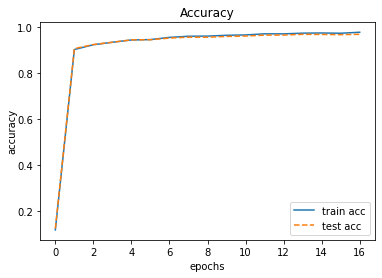

In [17]:
import matplotlib.pyplot as plt
plt.title("Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.plot(train_acc_list, label = 'train acc')
plt.plot(test_acc_list, label = 'test acc', linestyle = '--')
plt.legend(loc = 'best')
plt.show()

